# Import Important Library

In [126]:
import pandas as pd #for reaed data
import re #for text cleansing

from nltk.corpus import stopwords #for clean stopwords

#visualization
import matplotlib.pyplot as plt
import seaborn as sns 

## Read Data

In [127]:
dfText = pd.read_csv('dataset/train_preprocess.tsv', sep='\t', names=['text', 'label'])
dfText.head()

,text,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


In [128]:
dfAlay = pd.read_csv('dataset/new_kamusalay.csv', encoding='latin-1', names=['original', 'replacement'])
dfAlay

,original,replacement
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali
...,...,...
15162,mendikbud,menteri pendidikan dan kebudayaan
15163,mendag,menteri perdagangan
15164,menaker,menteri tenaga kerja
15165,memetwit,mentwit


In [129]:
dfStopWord = pd.read_csv('dataset/stopwordbahasa.csv', names=['stopword'])
dfStopWord

,stopword
0,gue
1,gua
2,ya
3,yg
4,ga
...,...
782,wong
783,yaitu
784,yakin
785,yakni


# Cleansing Text

In [130]:
# remove kata alay
alay_dict_map = dict(zip(dfAlay['original'], dfAlay['replacement']))
def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

# remove punctuation
def remove_punctuation(text):
    return re.sub(r'[^\w\s]',' ',text)

# remove stopword
stopword_list = set(stopwords.words('indonesian'))
def remove_stopword(text):
    return ' '.join([word for word in text.split(' ') if word not in stopword_list])


In [131]:
# test function
print("normalize_alay: ", normalize_alay("aamiin adek abis"))
print("remove punc: ", remove_punctuation("aku,kamu dua"))
print("remove stopword: ", remove_stopword("agaknya kamu cantik"))

normalize_alay:  amin adik habis
remove punc:  aku kamu dua
remove stopword:  cantik


In [132]:
def preprocess(text):
    text = normalize_alay(text)
    text = remove_punctuation(text)
    text = remove_stopword(text)
    return text

In [133]:
dfText['text'] = dfText['text'].apply(preprocess)
dfText['text'] = dfText['text'].str.lower()
dfText

,text,label
0,warung dimiliki pengusaha pabrik puluhan terke...,positive
1,mohon ulama lurus k212 mmbri hujjah partai diw...,neutral
2,lokasi strategis jalan sumatra bandung nya n...,positive
3,betapa bahagia nya unboxing paket barang nya b...,positive
4,aduh mahasiswa sombong kasih kartu kuning ...,negative
...,...,...
10995,kecewa,positive
10996,enak masakan nya kepiting menyenangkan memilih...,positive
10997,hormati partai partai berkoalisi,neutral
10998,pagi pagi tol pasteur macet parah bikin jengkel,negative


In [146]:
dictLabel = {'positive' : 1, 'neutral' : 0, 'negative' : 2}
dfText['label'] = dfText['label'].map(dictLabel)
dfText['label']

0        1
1        0
2        1
3        1
4        2
        ..
10995    1
10996    1
10997    0
10998    2
10999    1
Name: label, Length: 11000, dtype: int64

# EDA

## Check Info Data

In [135]:
len(dfText)

11000

In [136]:
dfText.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    11000 non-null  object
 1   label   11000 non-null  object
dtypes: object(2)
memory usage: 172.0+ KB


In [137]:
dfText.isnull().sum()

text     0
label    0
dtype: int64

# Tf-idf Transformer

In [147]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from keras_preprocessing.sequence import pad_sequences

In [148]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(dfText['text'])
X_train_counts.shape

(11000, 15751)

In [149]:
tf_tranformer =TfidfTransformer(smooth_idf=True,use_idf=True).fit(X_train_counts)
X_train_tf = tf_tranformer.transform(X_train_counts).toarray()
X_train_tf.shape

(11000, 15751)

# Tokenization and Change Label to Categorical

In [150]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

In [151]:
arrayLabel = dfText['label'].to_numpy()

In [153]:
import tensorflow as tf

labels = tf.keras.utils.to_categorical(arrayLabel, 3, dtype="float32")

In [154]:
len(labels)

11000

In [86]:
max_words = 11000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(dfText['text'])
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(dfText['text'])
text = pad_sequences(sequences, maxlen=max_len)
print(text.shape)

(11000, 200)


# Training

In [87]:
from keras.models import Sequential, load_model
from keras import layers
from keras.optimizers import RMSprop,Adam   
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint

## Split Data

In [163]:
# split tfidftransformers data
from sklearn.model_selection import train_test_split

X_train_transf, X_test_transf, y_train_transf, y_test_transf = train_test_split(X_train_tf,labels, random_state=0)
print(len(X_train_transf),len(X_test_transf),len(y_train_transf),len(y_test_transf))

8250 2750 8250 2750


In [164]:
# split tokenization data
from sklearn.model_selection import train_test_split

X_train_token, X_test_token, y_train_token, y_test_token = train_test_split(text,labels, random_state=0)
print(len(X_train_token),len(X_test_token),len(y_train_token),len(y_test_token))

8250 2750 8250 2750


## LSTM

In [166]:
model1 = Sequential()
model1.add(layers.Embedding(max_words, 20))
model1.add(layers.LSTM(15,dropout=0.5))
model1.add(layers.Dense(3,activation='softmax'))


model1.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint1 = ModelCheckpoint("best_model1.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model1.fit(X_train_token, y_train_token, epochs=70,validation_data=(X_test_token, y_test_token),callbacks=[checkpoint1])

Epoch 1/70


KeyboardInterrupt: 

## ANN

In [171]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(hidden_layer_sizes=(256,128,64,32), activation="relu",random_state=1, solver='adam', alpha=1e-5, early_stopping=True, max_iter=1000, verbose=True)
clf.fit(X_train_transf,y_train_transf)

Iteration 1, loss = 0.89445471
Validation score: 0.784242
Iteration 2, loss = 0.43397681
Validation score: 0.809697
Iteration 3, loss = 0.22079768
Validation score: 0.843636
Iteration 4, loss = 0.08640919
Validation score: 0.843636
Iteration 5, loss = 0.04577407
Validation score: 0.835152
Iteration 6, loss = 0.03442475
Validation score: 0.832727
Iteration 7, loss = 0.02899044
Validation score: 0.820606
Iteration 8, loss = 0.02578073
Validation score: 0.829091
Iteration 9, loss = 0.02516976
Validation score: 0.827879
Iteration 10, loss = 0.02443949
Validation score: 0.819394
Iteration 11, loss = 0.02296206
Validation score: 0.810909
Iteration 12, loss = 0.02499877
Validation score: 0.821818
Iteration 13, loss = 0.02176930
Validation score: 0.819394
Iteration 14, loss = 0.02046270
Validation score: 0.821818
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


MLPClassifier(alpha=1e-05, early_stopping=True,
              hidden_layer_sizes=(256, 128, 64, 32), max_iter=1000,
              random_state=1, verbose=True)

In [172]:
y_pred=clf.predict(X_test_transf)

# Validation

In [99]:
import numpy as np
import keras
from sklearn.metrics import confusion_matrix

## LSTM

In [100]:
best_model = keras.models.load_model("best_model1.hdf5")

In [101]:
test_loss, test_acc = best_model.evaluate(X_test_token, y_test_token, verbose=2)
print('Model accuracy: ',test_acc)

86/86 - 2s - loss: 0.4186 - accuracy: 0.8520 - 2s/epoch - 23ms/step
Model accuracy:  0.8519999980926514


In [102]:
predictions = best_model.predict(X_test_token)

86/86 [==============================] - 2s 14ms/step


In [103]:
matrix = confusion_matrix(y_test_token.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))

C:\Users\ansha\AppData\Local\Temp/ipykernel_10152/3444368053.py:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


<AxesSubplot:>

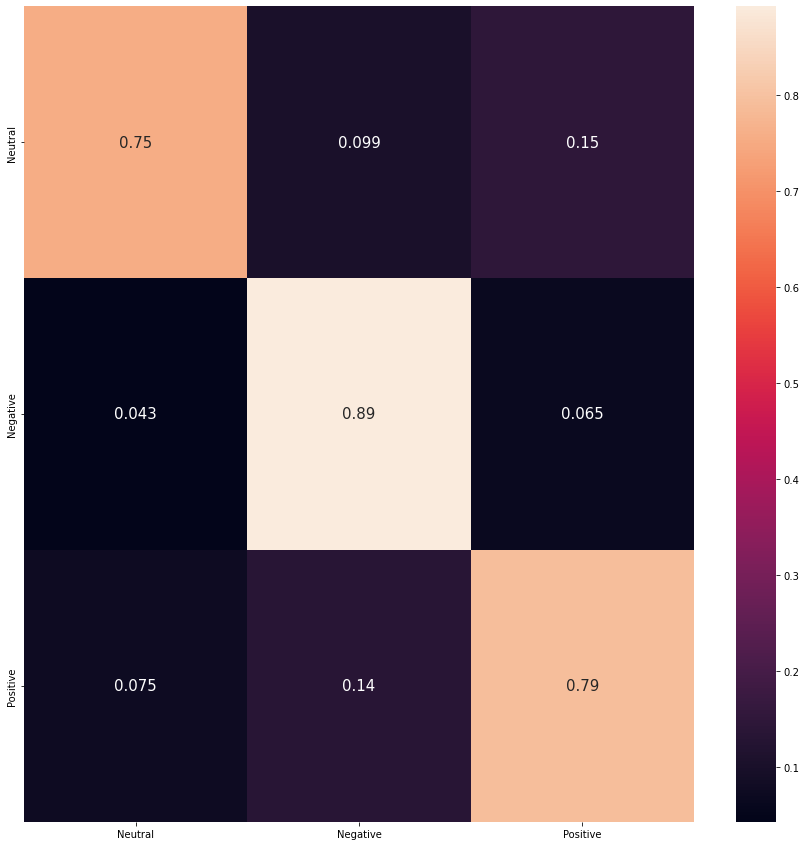

In [104]:
conf_matrix = pd.DataFrame(matrix, index = ['Neutral','Negative','Positive'],columns = ['Neutral','Negative','Positive'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

In [105]:
label = ['Neutral','Positive','Negative']

In [114]:
sequence = tokenizer.texts_to_sequences(['kamu baik banget'])
test = pad_sequences(sequence, maxlen=max_len)
label[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 106ms/step


'Positive'

## ANN

In [175]:
import numpy as np
np.mean(y_pred == y_test_transf)

0.8250909090909091

In [174]:
from sklearn.metrics import classification_report

print(classification_report(y_test_transf, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.56      0.65       292
           1       0.88      0.89      0.88      1594
           2       0.74      0.80      0.77       864

    accuracy                           0.83      2750
   macro avg       0.80      0.75      0.77      2750
weighted avg       0.83      0.83      0.82      2750

